In [32]:
%matplotlib inline
from scipy import *
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider
import model_base as mb
from experiments import get_null_ff_input_arrays
from IPython.display import display


In [14]:
def slice_dict(dic, ts, te):

    dic_new = dict()
    for k in dic.keys():
        dic_new[k] = dic[k][ts:te]

    return dic_new

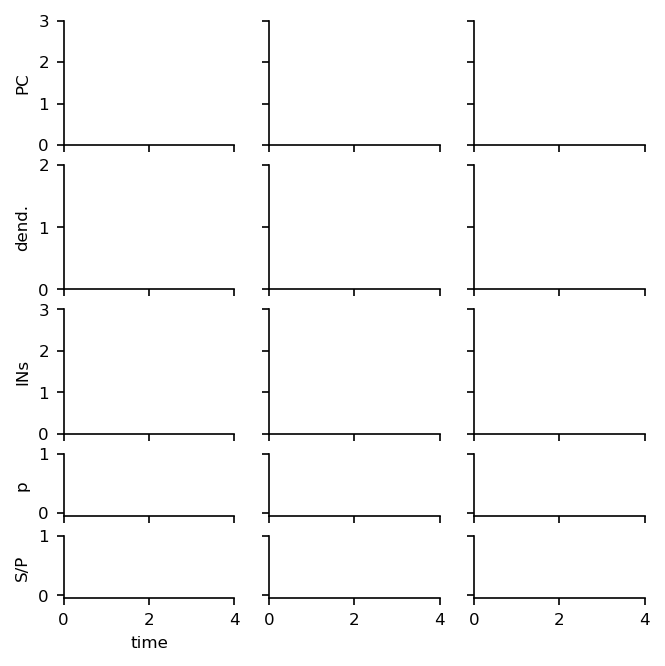

interactive(children=(FloatSlider(value=0.6, description='DN', max=2.0, step=0.2), FloatSlider(value=0.6, desc…

In [38]:

## Definition of the plot_cos function, our "callback function".
def interact_PvsS_response():
    
    fig, ax = plt.subplots(5, 3, dpi=150, figsize=(5,5), sharex=True, sharey='row',
                           gridspec_kw={'height_ratios': [1, 1, 1, 0.5, 0.5]})
    titles = ['P=S', 'P>S', 'P<S']
    
    lines_rE = []
    lines_rD = []
    lines_rP = []
    lines_rS = []
    lines_rN = []
    lines_p = []

    for i in range(3):
        lines_rE.append(ax[0, i].plot([], [], c='C3'))
        lines_rD.append(ax[1, i].plot([], [], c='k'))
        lines_rP.append(ax[2, i].plot([], [], c='darkblue'))
        lines_rS.append(ax[2, i].plot([], [], c='cornflowerblue'))
        lines_rN.append(ax[2, i].plot([], [], c='orange'))
        lines_p.append(ax[3, i].plot([], [], c='C2'))
        
        
    ax[0, 0].set(ylabel='PC', ylim=[0, 3], xlim=[0, 4])
    ax[1, 0].set(ylabel='dend.', ylim=[0, 2])
    ax[2, 0].set(ylabel='INs', ylim=[0, 3])
    ax[3, 0].set(ylabel='p', ylim=[-0.05, 1])
    ax[4, 0].set(ylabel='S/P', xlabel='time', ylim=[-0.05, 1])
    
    def plot_response(DN, DS, NS, rN0, rD0, pre_inh):
    
        # define parameter dictionaries
        N_cells, w_mean, conn_prob, bg_inputs, taus = mb.get_default_params(flag_mean_pop=True)

        # simplify network by removing recurrent connections
        w_mean.update(dict(PN=0.0, SE=0, PE=0))

        # play with parameters
        w_mean.update(dict(DN=DN, DS=DS, NS=NS))

        # instantiate model
        model = mb.NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_w_hetero=False, flag_pre_inh=pre_inh,
                            flag_with_NDNF=True, flag_with_VIP=False, flag_with_PV=True)

        # initial rates
        rN0 = rN0 # 1.9
        rS0 = 1
        rP0 = 1
        rV0 = 0
        rE0 = 1
        rD0 = rD0 #0
        p0 = model.g_func(rN0) # 0.01

        # simulation parameters
        dur_tot = 10000  # ms
        dt = 1  # ms
        t = np.arange(0, dur_tot, dt)
        nt = len(t)

        # construct input: fully prediced, overpredicted, underpredicted
        amp = 1
        fp_s, fp_e = 1000, 3000
        op_s, op_e = 4000, 6000
        up_s, up_e = 7000, 9000
        sensory = np.zeros(nt)
        sensory[fp_s:fp_e] = amp
        sensory[up_s:up_e] = amp
        prediction = np.zeros(nt)
        prediction[fp_s:fp_e] = amp
        prediction[op_s:op_e] = amp

        # set input of cells
        xFF = get_null_ff_input_arrays(nt, N_cells)
        xFF['E'] = np.tile(sensory, [N_cells['E'], 1]).T
        xFF['D'] = np.tile(prediction, [N_cells['D'], 1]).T
        xFF['P'] = np.tile(sensory, [N_cells['P'], 1]).T
        xFF['S'] = np.tile(sensory, [N_cells['S'], 1]).T
        xFF['V'] = np.tile(prediction, [N_cells['V'], 1]).T
        xFF['N'] = np.tile(prediction, [N_cells['N'], 1]).T

        # run network, simulate 3 conditions separately to avoid long-lasting effects
        dur = 4000
        buffer = 1000
        xFFfp = slice_dict(xFF, fp_s-buffer, fp_e+buffer)
        xFFop = slice_dict(xFF, op_s-buffer, op_e+buffer)
        xFFup = slice_dict(xFF, up_s-buffer, up_e+buffer)
        # t, rE, rD, rS, rN, rP, rV, p, cGABA, other = model.run(dur, xFF, dt=dt, rE0=1, rP0=4, rS0=4, rV0=4, rD0=0, p0=0.5, calc_bg_input=True)
        t, rEfp, rDfp, rSfp, rNfp, rPfp, rVfp, pfp, cGABAfp, other = model.run(dur, xFFfp, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=True)
        t, rEop, rDop, rSop, rNop, rPop, rVop, pop, cGABAop, other = model.run(dur, xFFop, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=True)
        t, rEup, rDup, rSup, rNup, rPup, rVup, pup, cGABAup, other = model.run(dur, xFFup, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=True)

        print(model.Xbg)
        t = t/1000

        ## Plot parameters
        xmin, xmax, nx = 0.0, 10.0, 50
        ymin, ymax     = -1.2, 1.2

        for i, cond in enumerate(['fp', 'op', 'up']):
            lines_rE[i][0].set_data(t, eval('rE'+cond))
            lines_rD[i][0].set_data(t, eval('rD'+cond))
            lines_rS[i][0].set_data(t, eval('rS'+cond))
            lines_rP[i][0].set_data(t, eval('rP'+cond))
            lines_rN[i][0].set_data(t, eval('rN'+cond))
            lines_p[i][0].set_data(t, eval('p'+cond))
            
#             ax[1, i].plot(t, eval('rD'+cond), c='k')
#             ax[2, i].plot(t, eval('rP'+cond), c='darkblue')
#             ax[2, i].plot(t, eval('rV'+cond), c='darkviolet')
#             ax[2, i].plot(t, eval('rS'+cond), c='cornflowerblue')
#             ax[2, i].plot(t, eval('rN'+cond), c='orange')
#             ax[3, i].plot(t, eval('p'+cond), c='C2')
#             ax[4, i].plot(t, sensory[eval(cond+'_s')-buffer:eval(cond+'_e')+buffer], c='gold')
#             ax[4, i].plot(t, prediction[eval(cond+'_s')-buffer:eval(cond+'_e')+buffer], c='teal', ls='--')
#             ax[0, i].set(title=titles[i])
            
        display(fig)
            
    ## Generate our user interface.
    interact(plot_response, DN=FloatSlider(min=0, max=2, step=0.2, value=0.6),
                                 DS=FloatSlider(min=0, max=2, step=0.2, value=0.6),
                                 NS=FloatSlider(min=0, max=2, step=0.2, value=0.8),
                                 rN0=FloatSlider(min=0, max=2, step=0.2, value=1),
                                 rD0=FloatSlider(min=0, max=2, step=0.2, value=1),
                                 pre_inh=FloatSlider(min=0, max=1, step=1, value=1));  
    

interact_PvsS_response()

